In [2]:
# Cell 1: Setup and Configuration
import cv2
import torch
import numpy as np
from PIL import Image
import torchvision.transforms as T
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from collections import Counter
import sys

# Add parent directory to path
sys.path.append('..')
from groundingdino.util.inference import load_model, predict

# ========== GLOBAL PARAMETERS ==========
BOX_THRESHOLD = 0.15
TEXT_THRESHOLD = 0.10
TEXT_PROMPT = "car. pedestrian."

# Sequence paths
FAILING_SEQ = "uav0000137_00458_v"  # Nighttime
#FAILING_SEQ = "uav0000117_02622_v"  # Nighttime
WORKING_SEQ = "uav0000086_00000_v"  # Daytime
DATA_ROOT = "../dataset/visdrone_mot_format/val"

print("✓ Configuration loaded")
print(f"  Box threshold: {BOX_THRESHOLD}")
print(f"  Text prompt: {TEXT_PROMPT}")

✓ Configuration loaded
  Box threshold: 0.15
  Text prompt: car. pedestrian.


In [3]:
# Cell 2: Load model
model = load_model(
    "../groundingdino/config/GroundingDINO_SwinB_cfg.py",
    "/isis/home/hasana3/vlmtest/GroundingDINO/output/visdrone_swinb_finetune_no_backbone_training/checkpoint_best_regular.pth"
).cuda().eval()

# Preprocessing transform
transform = T.Compose([
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    T.Resize((756, 1344), interpolation=T.InterpolationMode.BICUBIC)
])

print("✓ Model loaded and ready")

final text_encoder_type: bert-base-uncased
✓ Model loaded and ready


In [4]:
# Cell 3: Helper functions
def load_sequence_frame(seq_name, frame_num=1):
    """Load image and GT for a sequence"""
    img_path = f"{DATA_ROOT}/{seq_name}/img1/{frame_num:07d}.jpg"
    img_bgr = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    
    # Load GT for this frame
    gt_boxes = []
    gt_path = f"{DATA_ROOT}/{seq_name}/gt/gt.txt"
    with open(gt_path) as f:
        for line in f:
            parts = line.strip().split(',')
            if int(parts[0]) == frame_num:
                x, y, w, h = map(float, parts[2:6])
                track_id = int(parts[1])
                gt_boxes.append([x, y, w, h, track_id])
    
    return img_rgb, gt_boxes

def run_dino_detection(img_rgb):
    """Run DINO detection on an image"""
    img_pil = Image.fromarray(img_rgb)
    tensor = transform(img_pil).cuda()
    
    boxes, logits, phrases = predict(
        model=model,
        image=tensor,
        caption=TEXT_PROMPT,
        box_threshold=BOX_THRESHOLD,
        text_threshold=TEXT_THRESHOLD
    )
    
    return boxes, logits, phrases

def visualize_comparison(img_rgb, gt_boxes, dino_boxes, dino_logits, title_prefix=""):
    """Visualize GT vs DINO detections side-by-side"""
    H, W = img_rgb.shape[:2]
    
    fig, axes = plt.subplots(1, 2, figsize=(20, 8))
    
    # Left: Ground Truth
    axes[0].imshow(img_rgb)
    axes[0].set_title(f'{title_prefix} GT ({len(gt_boxes)} objects)', 
                     fontsize=14, fontweight='bold')
    for box in gt_boxes[:100]:
        x, y, w, h = box[:4]
        rect = patches.Rectangle((x, y), w, h, linewidth=2, 
                                 edgecolor='cyan', facecolor='none')
        axes[0].add_patch(rect)
    axes[0].axis('off')
    
    # Right: DINO Detections
    axes[1].imshow(img_rgb)
    axes[1].set_title(f'{title_prefix} DINO (thresh={BOX_THRESHOLD}, {len(dino_boxes)} detections)', 
                     fontsize=14, fontweight='bold')
    
    for box, score in zip(dino_boxes[:100], dino_logits[:100]):
        cx, cy, w, h = box
        x1 = (cx - w/2) * W
        y1 = (cy - h/2) * H
        box_w = w * W
        box_h = h * H
        
        rect = patches.Rectangle((x1, y1), box_w, box_h, linewidth=2,
                                 edgecolor='lime', facecolor='none')
        axes[1].add_patch(rect)
        axes[1].text(x1, y1-5, f"{score:.2f}", color='lime', 
                    fontsize=8, backgroundcolor='black')
    axes[1].axis('off')
    
    plt.tight_layout()
    plt.show()

def analyze_detection_quality(img_rgb, gt_boxes, dino_boxes, dino_logits, dino_phrases):
    """Print statistics about detection quality"""
    H, W = img_rgb.shape[:2]
    
    # GT statistics
    gt_areas = [w*h for x,y,w,h,_ in gt_boxes]
    
    # DINO statistics
    dino_areas = []
    dino_widths_norm = []
    dino_heights_norm = []
    
    for box in dino_boxes:
        cx, cy, w, h = box
        dino_widths_norm.append(w.item())
        dino_heights_norm.append(h.item())
        area = (w * W) * (h * H)
        dino_areas.append(area.item())
    
    print("="*60)
    print("DETECTION QUALITY ANALYSIS")
    print("="*60)
    print(f"\nGround Truth: {len(gt_boxes)} objects")
    print(f"  Area range: {min(gt_areas):.0f} - {max(gt_areas):.0f} px²")
    print(f"  Mean area: {np.mean(gt_areas):.0f} px²")
    
    print(f"\nDINO Detections: {len(dino_boxes)} objects")
    if len(dino_boxes) > 0:
        print(f"  Score range: {dino_logits.min():.3f} - {dino_logits.max():.3f}")
        print(f"  Mean score: {dino_logits.mean():.3f}")
        print(f"  Area range: {min(dino_areas):.0f} - {max(dino_areas):.0f} px²")
        print(f"  Mean area: {np.mean(dino_areas):.0f} px²")
        print(f"  Width (norm): {min(dino_widths_norm):.3f} - {max(dino_widths_norm):.3f} (mean: {np.mean(dino_widths_norm):.3f})")
        print(f"  Height (norm): {min(dino_heights_norm):.3f} - {max(dino_heights_norm):.3f} (mean: {np.mean(dino_heights_norm):.3f})")
        
        # Phrase distribution
        phrase_counts = Counter(dino_phrases)
        print(f"\n  Phrase distribution:")
        for phrase, count in phrase_counts.most_common(5):
            print(f"    {phrase:25s}: {count:3d}")
        
        # Detection rate
        recall = len(dino_boxes) / len(gt_boxes) * 100 if len(gt_boxes) > 0 else 0
        print(f"\n  Detection rate: {recall:.1f}% ({len(dino_boxes)}/{len(gt_boxes)})")
        
        # Check for oversized boxes
        oversized = sum(1 for w, h in zip(dino_widths_norm, dino_heights_norm) if w > 0.2 or h > 0.2)
        if oversized > 0:
            print(f"  ⚠️  {oversized} boxes are >20% of image size (likely false positives)")

print("✓ Helper functions loaded")

✓ Helper functions loaded


ANALYZING FAILING SEQUENCE (Daytime)


Sequence: uav0000137_00458_v
Image size: (1512, 2688, 3)
Brightness: 93.9
tensor([[0.4165, 0.4275, 0.0950, 0.0788],
        [0.5279, 0.4982, 0.0181, 0.0727],
        [0.2719, 0.8175, 0.0267, 0.1018],
        [0.2819, 0.4451, 0.0703, 0.0872],
        [0.3093, 0.6336, 0.0209, 0.0721],
        [0.1861, 0.3090, 0.0668, 0.0653],
        [0.2249, 0.7265, 0.1402, 0.1507],
        [0.4376, 0.3304, 0.0797, 0.0574],
        [0.3355, 0.6447, 0.0224, 0.0765],
        [0.4705, 0.4946, 0.1040, 0.0811],
        [0.3984, 0.6888, 0.0221, 0.0782],
        [0.2879, 0.7957, 0.0290, 0.0968],
        [0.2151, 0.4245, 0.0508, 0.0831],
        [0.7450, 0.3714, 0.0780, 0.0624],
        [0.1517, 0.4797, 0.0193, 0.0714],
        [0.2602, 0.5801, 0.0211, 0.0716],
        [0.5392, 0.4356, 0.0891, 0.0726],
        [0.7985, 0.2783, 0.0415, 0.0500],
        [0.3428, 0.7595, 0.0400, 0.0959],
        [0.4369, 0.5746, 0.1051, 0.1096],
        [0.8593, 0.2632, 0.0394, 0.0505],
        [0.2840, 0.2811, 0.0413, 0.0573],
  

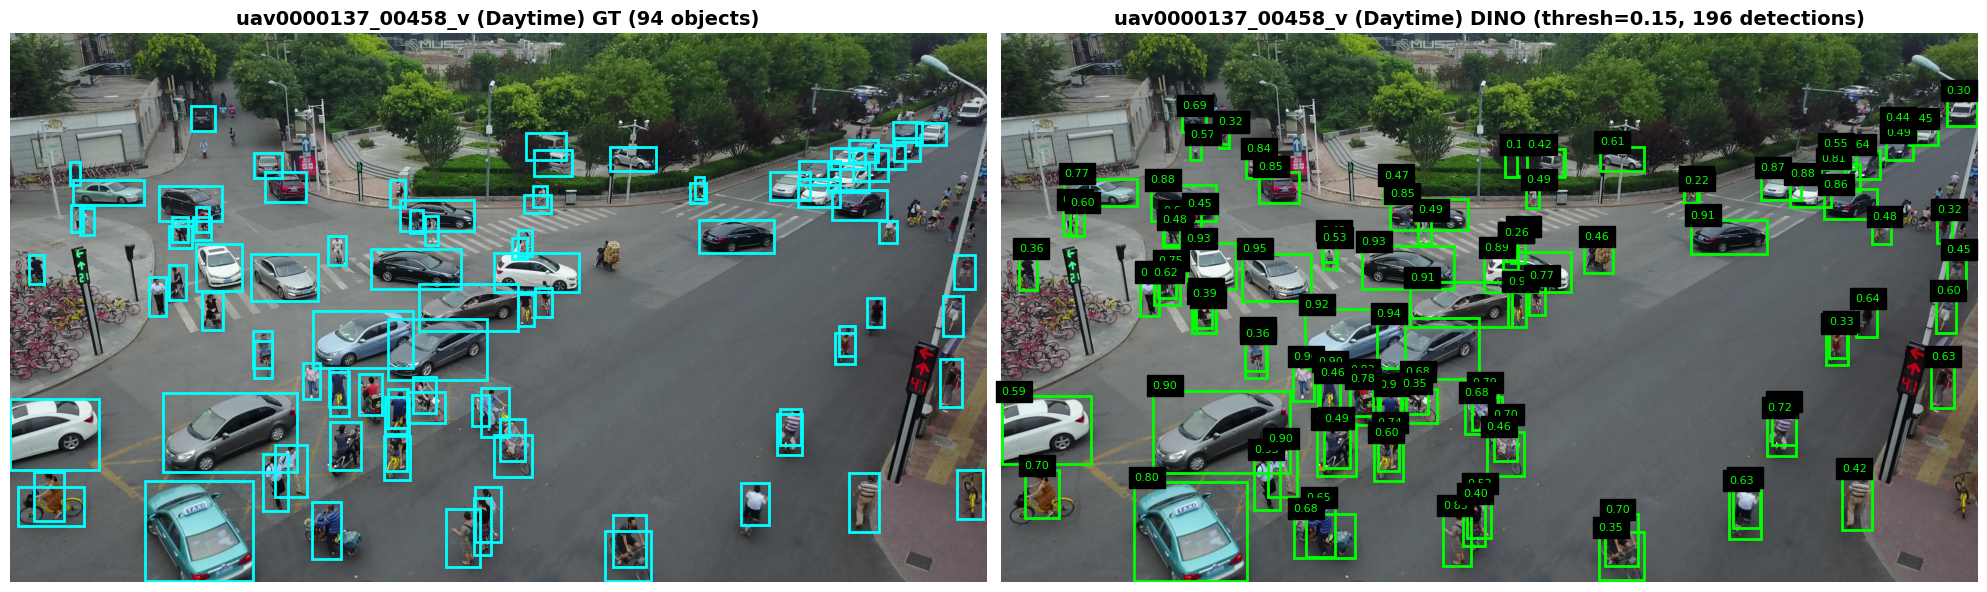

In [5]:
# Cell 4: Analyze FAILING sequence (nighttime)
def analyze_failing_sequence():
    print("ANALYZING FAILING SEQUENCE (Daytime)")
    print("="*60)
    """Load image and GT for a sequence"""
    frame_num = 1  # Analyze the first frame of the sequence
    img_path = f"{DATA_ROOT}/{FAILING_SEQ}/img1/{frame_num:07d}.jpg"
    img_bgr = cv2.imread(img_path)
    failing_img = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    failing_gt = []

    gt_boxes = []
    gt_path = f"{DATA_ROOT}/{FAILING_SEQ}/gt/gt.txt"
    with open(gt_path) as f:
        for line in f:
            parts = line.strip().split(',')
            if int(parts[0]) == frame_num:
                x, y, w, h = map(float, parts[2:6])
                track_id = int(parts[1])
                failing_gt.append([x, y, w, h, track_id])
    """Run DINO detection on an image"""
    img_pil = Image.fromarray(failing_img)
    tensor = transform(img_pil).cuda()
    
    failing_boxes, failing_logits, failing_phrases = predict(
        model=model,
        image=tensor,
        caption=TEXT_PROMPT,
        box_threshold=BOX_THRESHOLD,
        text_threshold=TEXT_THRESHOLD
    )
    
    print(f"Sequence: {FAILING_SEQ}")
    print(f"Image size: {failing_img.shape}")
    print(f"Brightness: {failing_img.mean():.1f}")
    print(failing_boxes, failing_logits, failing_phrases)

    visualize_comparison(failing_img, failing_gt, failing_boxes, 
                        failing_logits, f"{FAILING_SEQ} (Daytime)")

analyze_failing_sequence()

ANALYZING FAILING SEQUENCE (Nighttime)
Sequence: uav0000137_00458_v
Image size: (1512, 2688, 3)
Brightness: 93.9
tensor([[0.4165, 0.4275, 0.0950, 0.0788],
        [0.5279, 0.4982, 0.0181, 0.0727],
        [0.2719, 0.8175, 0.0267, 0.1018],
        [0.2819, 0.4451, 0.0703, 0.0872],
        [0.3093, 0.6336, 0.0209, 0.0721],
        [0.1861, 0.3090, 0.0668, 0.0653],
        [0.2249, 0.7265, 0.1402, 0.1507],
        [0.4376, 0.3304, 0.0797, 0.0574],
        [0.3355, 0.6447, 0.0224, 0.0765],
        [0.4705, 0.4946, 0.1040, 0.0811],
        [0.3984, 0.6888, 0.0221, 0.0782],
        [0.2879, 0.7957, 0.0290, 0.0968],
        [0.2151, 0.4245, 0.0508, 0.0831],
        [0.7450, 0.3714, 0.0780, 0.0624],
        [0.1517, 0.4797, 0.0193, 0.0714],
        [0.2602, 0.5801, 0.0211, 0.0716],
        [0.5392, 0.4356, 0.0891, 0.0726],
        [0.7985, 0.2783, 0.0415, 0.0500],
        [0.3428, 0.7595, 0.0400, 0.0959],
        [0.4369, 0.5746, 0.1051, 0.1096],
        [0.8593, 0.2632, 0.0394, 0.0505],
     

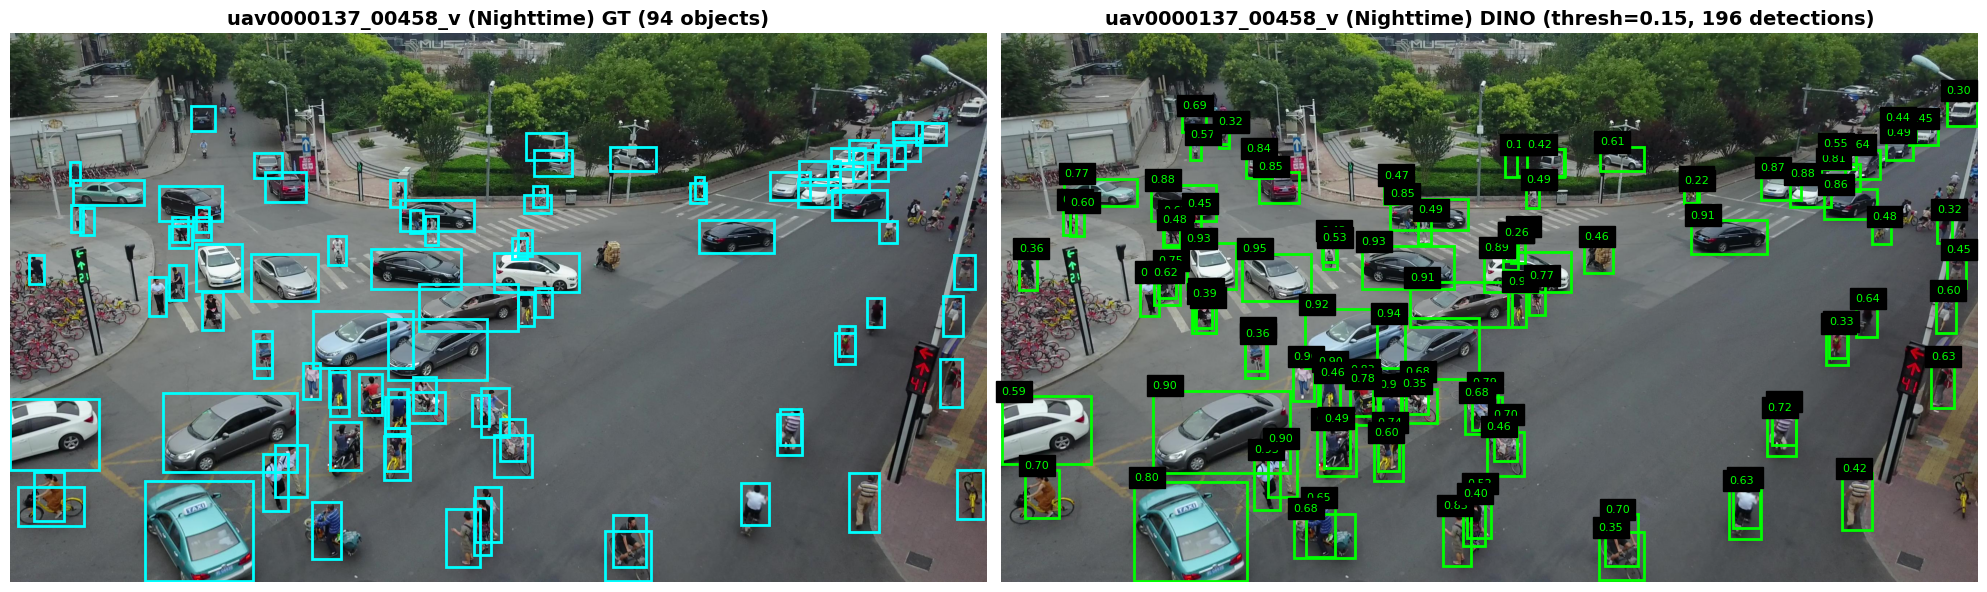

In [6]:
# Cell 4: Analyze FAILING sequence (nighttime)
print("ANALYZING FAILING SEQUENCE (Nighttime)")
print("="*60)

failing_img, failing_gt = load_sequence_frame(FAILING_SEQ)
failing_boxes, failing_logits, failing_phrases = run_dino_detection(failing_img)

print(f"Sequence: {FAILING_SEQ}")
print(f"Image size: {failing_img.shape}")
print(f"Brightness: {failing_img.mean():.1f}")
print(failing_boxes, failing_logits, failing_phrases)

analyze_detection_quality(failing_img, failing_gt, failing_boxes, 
                         failing_logits, failing_phrases)

visualize_comparison(failing_img, failing_gt, failing_boxes, 
                    failing_logits, f"{FAILING_SEQ} (Nighttime)")


ANALYZING WORKING SEQUENCE (Daytime)
Sequence: uav0000086_00000_v
Image size: (756, 1344, 3)
Brightness: 95.7
DETECTION QUALITY ANALYSIS

Ground Truth: 34 objects
  Area range: 540 - 8464 px²
  Mean area: 2634 px²

DINO Detections: 48 objects
  Score range: 0.153 - 0.974
  Mean score: 0.642
  Area range: 702 - 7624 px²
  Mean area: 2518 px²
  Width (norm): 0.014 - 0.063 (mean: 0.028)
  Height (norm): 0.035 - 0.167 (mean: 0.081)

  Phrase distribution:
    pedestrian               :  43
    car                      :   3
    pedestrian car           :   2

  Detection rate: 141.2% (48/34)


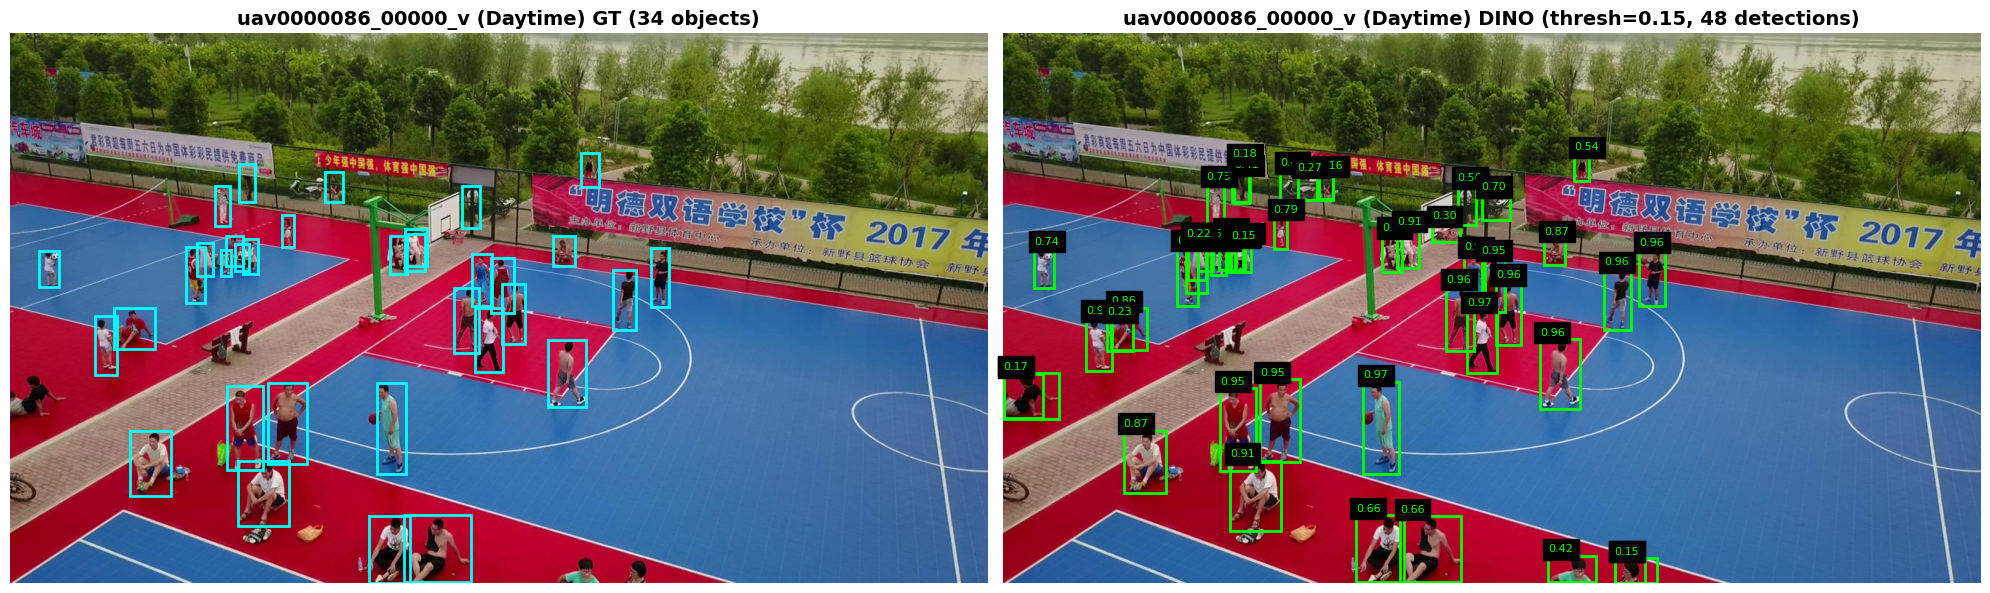

In [64]:
# Cell 5: Analyze WORKING sequence (daytime)
print("\nANALYZING WORKING SEQUENCE (Daytime)")
print("="*60)

working_img, working_gt = load_sequence_frame(WORKING_SEQ)
working_boxes, working_logits, working_phrases = run_dino_detection(working_img)

print(f"Sequence: {WORKING_SEQ}")
print(f"Image size: {working_img.shape}")
print(f"Brightness: {working_img.mean():.1f}")

analyze_detection_quality(working_img, working_gt, working_boxes, 
                         working_logits, working_phrases)

visualize_comparison(working_img, working_gt, working_boxes, 
                    working_logits, f"{WORKING_SEQ} (Daytime)")

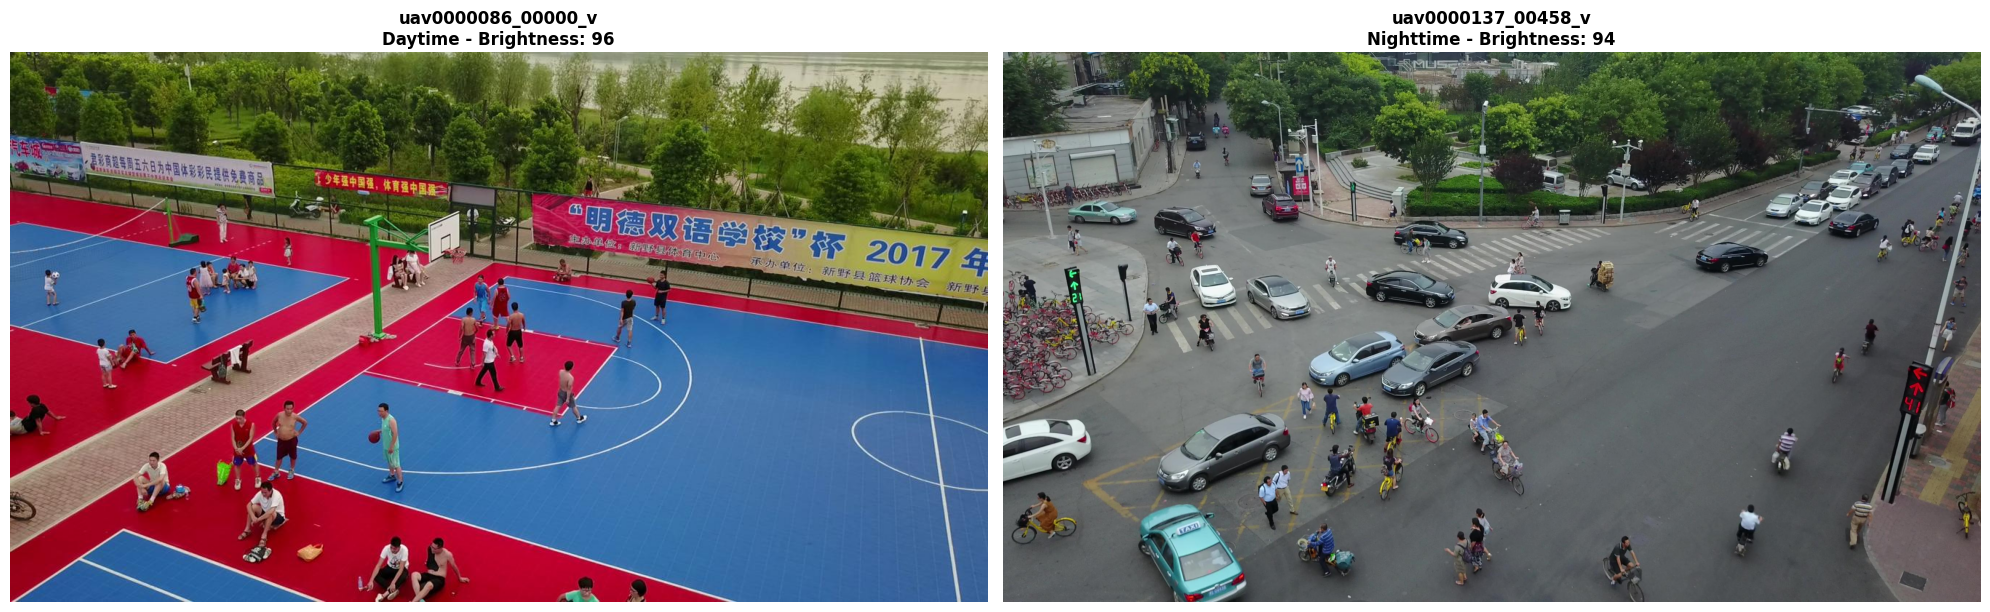


SUMMARY
Daytime:   48/34 detections (141.2%)
Nighttime: 0/94 detections (0.0%)


In [65]:
# Cell 6: Compare both sequences side-by-side
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

axes[0].imshow(working_img)
axes[0].set_title(f'{WORKING_SEQ}\nDaytime - Brightness: {working_img.mean():.0f}', 
                 fontsize=12, fontweight='bold')
axes[0].axis('off')

axes[1].imshow(failing_img)
axes[1].set_title(f'{FAILING_SEQ}\nNighttime - Brightness: {failing_img.mean():.0f}', 
                 fontsize=12, fontweight='bold')
axes[1].axis('off')

plt.tight_layout()
plt.show()

print("\nSUMMARY")
print("="*60)
print(f"Daytime:   {len(working_boxes)}/{len(working_gt)} detections ({len(working_boxes)/len(working_gt)*100:.1f}%)")
print(f"Nighttime: {len(failing_boxes)}/{len(failing_gt)} detections ({len(failing_boxes)/len(failing_gt)*100:.1f}%)")

In [66]:
# Cell 7: Threshold sensitivity analysis (optional)
print("THRESHOLD SENSITIVITY ANALYSIS")
print("="*60)

test_thresholds = [0.02, 0.04, 0.06, 0.08, 0.10, 0.12]

for thresh in test_thresholds:
    boxes_t, logits_t, _ = predict(
        model=model,
        image=transform(Image.fromarray(working_img)).cuda(),
        caption=TEXT_PROMPT,
        box_threshold=thresh,
        text_threshold=thresh
    )
    
    ratio = len(boxes_t) / len(working_gt) if len(working_gt) > 0 else 0
    print(f"Threshold {thresh:.2f}: {len(boxes_t):4d} detections | "
          f"GT: {len(working_gt):3d} | Ratio: {ratio:5.2f}x | "
          f"Scores: {logits_t.min():.3f}-{logits_t.max():.3f}")

THRESHOLD SENSITIVITY ANALYSIS
Threshold 0.02:  843 detections | GT:  34 | Ratio: 24.79x | Scores: 0.020-0.974


Threshold 0.04:  482 detections | GT:  34 | Ratio: 14.18x | Scores: 0.040-0.974
Threshold 0.06:  182 detections | GT:  34 | Ratio:  5.35x | Scores: 0.060-0.974
Threshold 0.08:  107 detections | GT:  34 | Ratio:  3.15x | Scores: 0.081-0.974
Threshold 0.10:   77 detections | GT:  34 | Ratio:  2.26x | Scores: 0.101-0.974
Threshold 0.12:   62 detections | GT:  34 | Ratio:  1.82x | Scores: 0.120-0.974
